In [1]:
import os
os.chdir("..")
import relegy.embeddings as rle
import relegy.metrics as rlm
os.chdir("Analysis")

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import inspect
from IPython.display import clear_output
from matplotlib.pylab import rcParams
import sys

In [3]:
def get_embedding_methods_iterable():
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

In [4]:
def generate_clusters_graph(n, k, p):
    partition = np.random.multinomial(n, np.ones(k)/k, size=1)[0]
    labels = np.repeat(np.arange(k), partition)
    G = nx.Graph()
    cur_min = 0
    for i in partition:
        ng = nx.complete_graph(range(cur_min, cur_min+i))
        G.add_nodes_from(ng)
        G.add_edges_from(ng.edges)
        cur_min += i
#     perm = np.random.permutation(G.nodes)
#     labs = dict(enumerate(perm))
#     G = nx.relabel_nodes(G, labs)
    G1 = nx.complement(G)
    arr = np.arange(len(G1.edges))
    new_edges_size = np.floor(p*len(arr))
    new_edges = np.random.choice(arr, size=new_edges_size.astype(int))
    G.add_edges_from(np.array(G1.edges)[new_edges,:])
    return G, labels

In [14]:
G, labels = generate_clusters_graph(100, 7, 0.03)

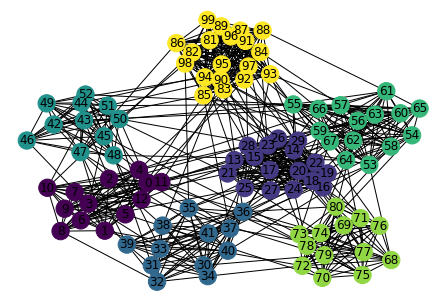

In [17]:
nx.draw(G, with_labels=True, node_color=labels)
plt.savefig("../../graf.png")

# LaplacianEigenmaps fast_embed

In [7]:
Z_le = rle.LaplacianEigenmaps.fast_embed(G, num_iter=300, d=3)

Iteration limit reached    (Exit mode 9)
            Current function value: [0.25526973]
            Iterations: 300
            Function evaluations: 1942
            Gradient evaluations: 300


In [8]:
Z_scaled = StandardScaler().fit_transform(Z_le)
Z_le_pca = PCA(n_components=2).fit_transform(Z_scaled)

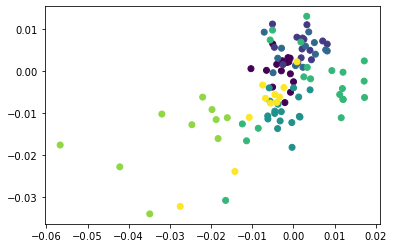

In [9]:
plt.scatter(Z_le[:, 0], Z_le[:, 1], c=labels)

# GraphFactorization

In [10]:
gf = rle.GraphFactorization(G)

gf.initialize(d = 2)
gf.initialize_model(lr=0.01)
gf.fit(num_iter = 300)
Z_gf = gf.embed()

Epoch 1: 829.2719
Epoch 2: 824.0355
Epoch 3: 817.0157
Epoch 4: 808.13007
Epoch 5: 797.31885
Epoch 6: 784.52814
Epoch 7: 769.7065
Epoch 8: 752.8056
Epoch 9: 733.782
Epoch 10: 712.602
Epoch 11: 689.24695
Epoch 12: 663.7197
Epoch 13: 636.051
Epoch 14: 606.3057
Epoch 15: 574.5874
Epoch 16: 541.043
Epoch 17: 505.8656
Epoch 18: 469.29565
Epoch 19: 431.6219
Epoch 20: 393.18152
Epoch 21: 354.35965
Epoch 22: 315.58786
Epoch 23: 277.34094
Epoch 24: 240.1317
Epoch 25: 204.50241
Epoch 26: 171.01186
Epoch 27: 140.21765
Epoch 28: 112.65165
Epoch 29: 88.7886
Epoch 30: 69.00708
Epoch 31: 53.545067
Epoch 32: 42.454113
Epoch 33: 35.559948
Epoch 34: 32.44074
Epoch 35: 32.434807
Epoch 36: 34.686554
Epoch 37: 38.23028
Epoch 38: 42.09989
Epoch 39: 45.44258
Epoch 40: 47.611843
Epoch 41: 48.221222
Epoch 42: 47.152042
Epoch 43: 44.52105
Epoch 44: 40.62127
Epoch 45: 35.851738
Epoch 46: 30.64906
Epoch 47: 25.429846
Epoch 48: 20.548574
Epoch 49: 16.271906
Epoch 50: 12.768354
Epoch 51: 10.110628
Epoch 52: 8.287394

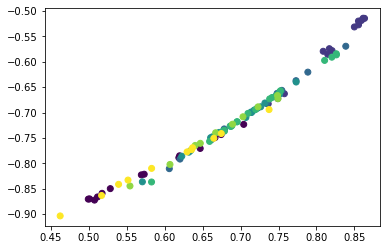

In [11]:
plt.scatter(Z_gf[:, 0], Z_gf[:, 1], c=labels)

In [19]:
obtained_matrix = Z_gf @ Z_gf.T

In [20]:
rmse = rlm.rmse(nx.to_numpy_array(G, nodelist=G.nodes), obtained_matrix)

patk = rlm.precision_at_k(nx.to_numpy_array(G, nodelist=G.nodes), obtained_matrix)

In [21]:
print(rmse)

0.8904971026331567


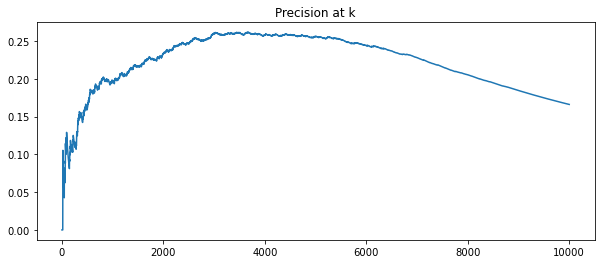

In [22]:
rcParams["figure.figsize"] = 10, 4
plt.plot(patk)
plt.title("Precision at k")
plt.show()

In [12]:
gf.fit(10)

Epoch 1: 5.1021004
Epoch 2: 5.1015472
Epoch 3: 5.101
Epoch 4: 5.1004543
Epoch 5: 5.0999136
Epoch 6: 5.0993757
Epoch 7: 5.0988426
Epoch 8: 5.0983124
Epoch 9: 5.097785
Epoch 10: 5.097262


In [13]:
results_dictionary = {}
for name, class_handle in get_embedding_methods_iterable():
    if not (name == "GCN" or name == "GNN"):
        print("Currently processing " + str(name))
        results_dictionary[name] = class_handle.fast_embed(G, d=2)
        clear_output()

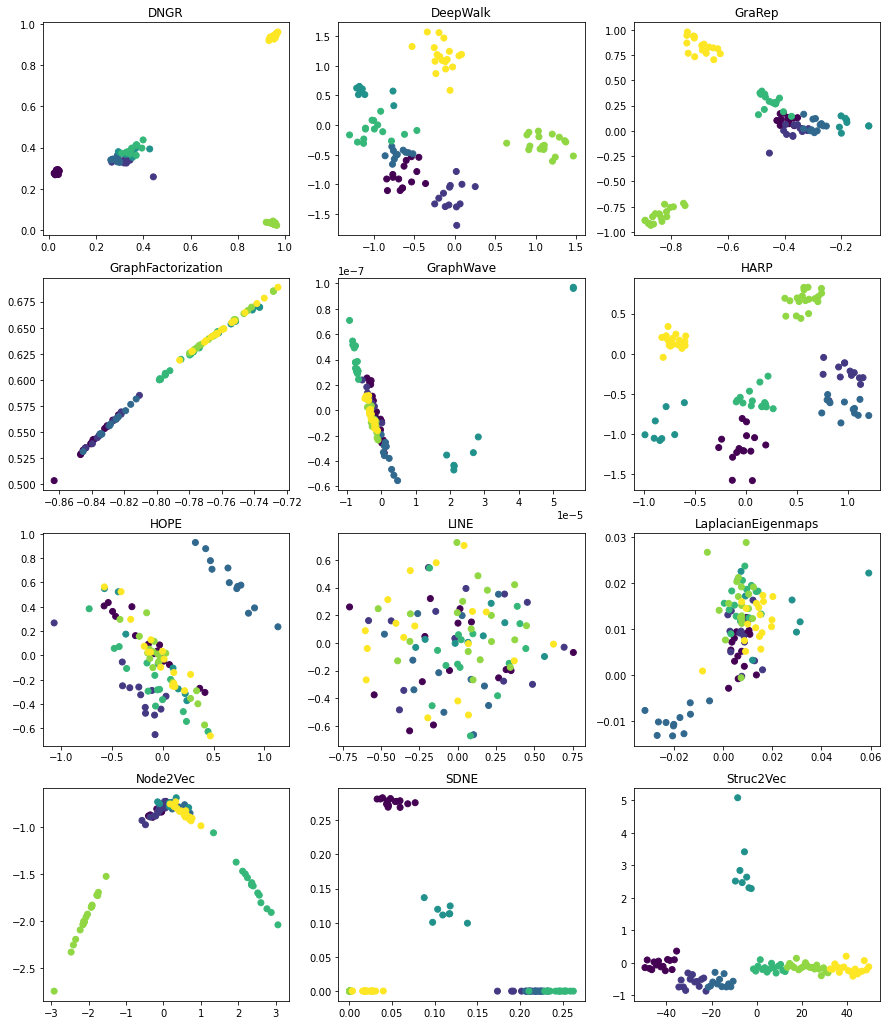

In [54]:
rcParams["figure.figsize"] = 15, 18
fig, axs = plt.subplots(4, 3)
names = list(results_dictionary.keys())
for i in range(len(names)):
    ix_x = i // 3
    ix_y = i % 3
    cur_Z = results_dictionary[names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
    axs[ix_x, ix_y].set_title(names[i])

In [18]:
results_dictionary = {}
for name, class_handle in get_embedding_methods_iterable():
    if not (name == "GCN" or name == "GNN"):
        print("Currently processing " + str(name))
        results_dictionary[name] = class_handle.fast_embed(G, d=5)
        clear_output()

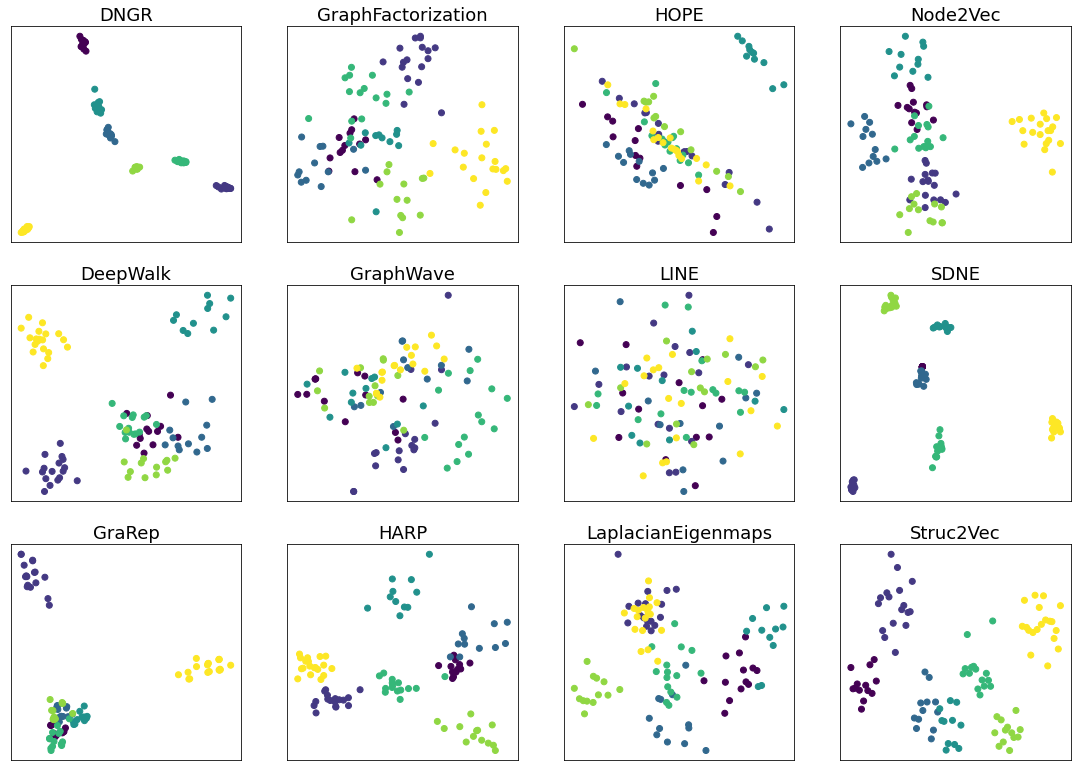

In [29]:
rcParams["figure.figsize"] = 19, 13.5
fig, axs = plt.subplots(3, 4)
names = list(results_dictionary.keys())
for i in range(len(names)):
    ix_x = i % 3
    ix_y = i // 3
    cur_Z = results_dictionary[names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
    axs[ix_x, ix_y].set_title(names[i], size=18)
    axs[ix_x, ix_y].set_xticks([])
    axs[ix_x, ix_y].set_yticks([])
plt.savefig("../../PCA.png")

In [62]:
import relegy.graphs as rlr

In [69]:
G = rlr.generate_graph("barbell", m1=20, m2=5)

kG, labels = rlr.get_karate_graph()

In [79]:
node_labs = node_color=np.array(labels)[:, 1]
_, ix = np.unique(node_labs, return_inverse=True)

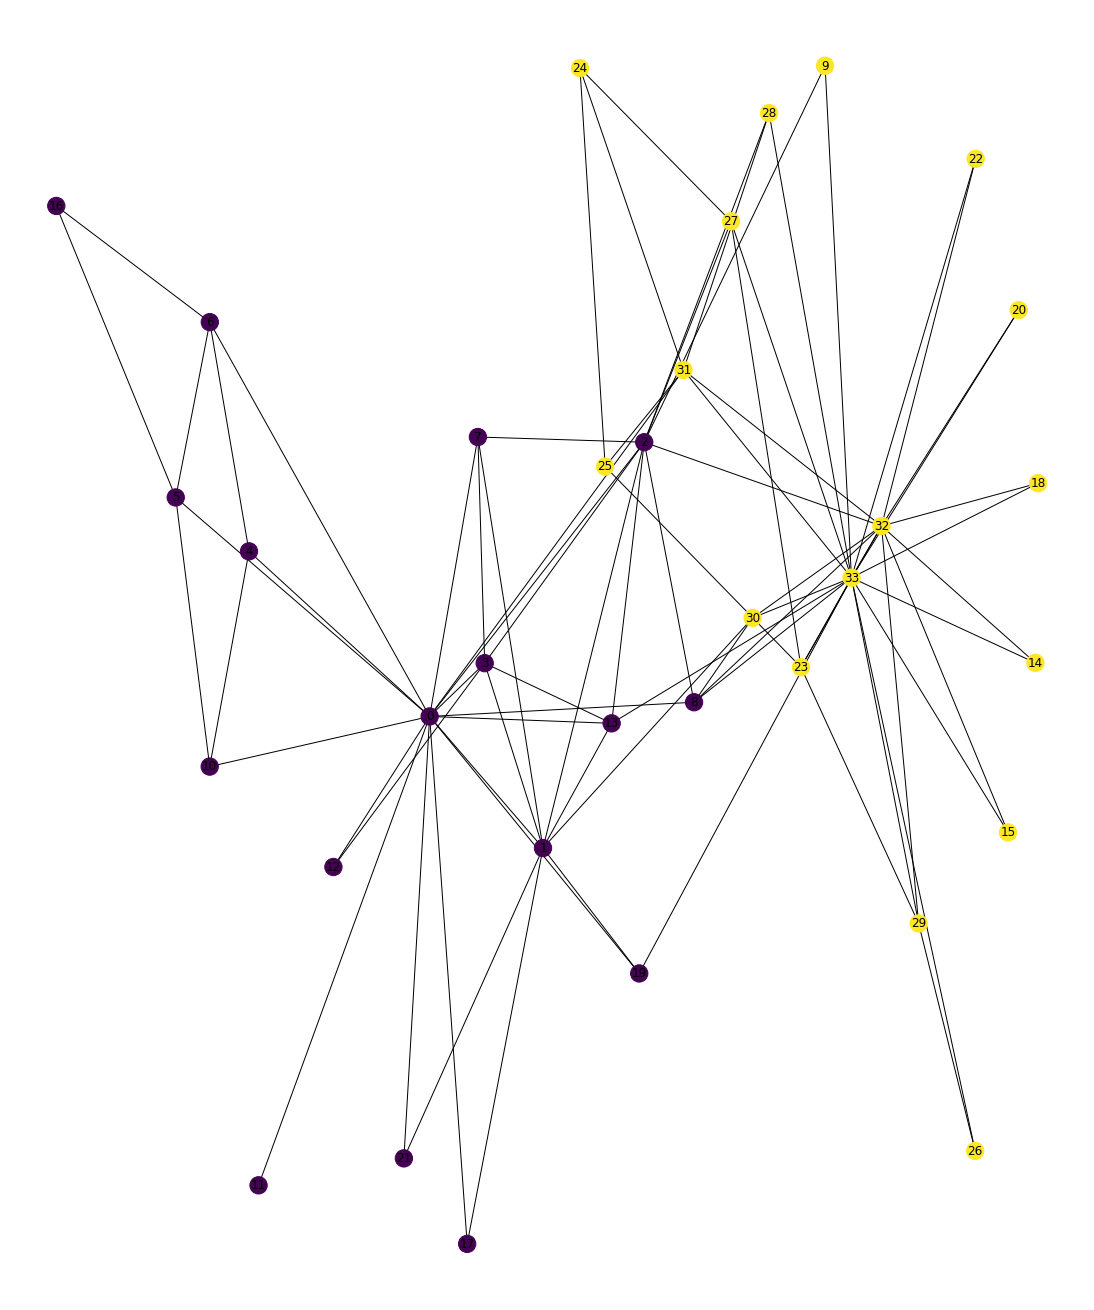

In [82]:
nx.draw(kG, with_labels=True, node_color=ix)